In [21]:
import fastai
import math
import os
import pprint
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils

from datetime import (
    datetime
)

from sklearn.preprocessing import (
    StandardScaler
)

from fastai.tabular.all import (
    LinBnDrop
)

from fastai.layers import (
    Identity

)

from typing import (
    Callable,
    Dict,
    List,
    Tuple
)

from Quick.cleaning.loading import (
    examine_dataset,
    remove_infs_and_nans
)

from Quick.cleaning.utils import (
    get_file_path
)

from Quick.runners.deep import (
    run_deep_nn_experiment
)

from Quick.runners.residual import (
    run_residual_deep_nn_experiment
)

from Quick.runners.sk import (
    run_sk_experiment
)

from Quick.runners.torch import (
    run_torch_nn_experiment
)

from rff.layers import (
    GaussianEncoding,
)

from Quick.constants import *

pretty = pprint.PrettyPrinter(indent=4).pprint

In [2]:
use_gpu: bool = False

if(use_gpu):

    if(torch.backends.mps.is_available()): # For Mac M1/M2 chips
        device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    else: # For NVIDIA cuda chips
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

else:
    device = torch.device('cpu')

print(f'We are currently using the device: {device}')

We are currently using the device: cpu


In [3]:
df = pd.read_csv(r"C:\python\TrafficFlowForecasting\warins_experiments\data\Scenario A1\TimeBasedFeatures-Dataset-15s-VPN.csv")

df = df.drop(columns=['Unnamed: 0'])
df.head()

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
0,9368711.0,16.0,4.0,1564818.0,1549373.0,190205.285714,203290.456522,389822.391917,370323.719754,10.353612,...,267600.198443,1871488.0,1.983656e+06,2195089.0,1.832197e+05,1234883.0,1420565.0,1523088.0,161096.539275,Non-VPN
1,7340238.0,18.0,4.0,1567554.0,1527893.0,165686.977273,186914.846154,317267.548742,304370.651301,11.580006,...,221462.862028,1491627.0,3.572433e+06,5653239.0,2.942704e+06,1131498.0,1324636.0,1517774.0,273138.379008,Non-VPN
2,4644225.0,29.0,15.0,1270547.0,1079974.0,165865.178571,195302.130435,329473.126261,300492.588227,11.412022,...,217475.425246,1758922.0,1.758922e+06,1758922.0,0.000000e+00,1079974.0,1079974.0,1079974.0,0.000000,Non-VPN
3,4978735.0,19.0,8.0,2492050.0,2457286.0,239543.250000,276596.388889,612435.304238,628339.573544,8.034169,...,436959.716436,1710925.0,2.382905e+06,3054885.0,9.503232e+05,1346073.0,1894031.5,2441990.0,774930.342317,Non-VPN
4,11838189.0,19.0,10.0,3094089.0,3093543.0,243766.500000,295954.725000,599721.781709,625632.703972,7.602514,...,436129.639296,1747431.0,2.400446e+06,3240696.0,6.232744e+05,1394455.0,1983227.0,3042717.0,725987.829075,Non-VPN


In [5]:
df.to_csv(r'C:\python\TrafficFlowForecasting\warins_experiments\data\Scenario A1\TimeBasedFeatures-Dataset-15s-VPN.csv', index=False)

In [6]:
data_path_1: str = r'C:\python\TrafficFlowForecasting\warins_experiments\data\Scenario A1'
data_sets_1: list = [
    'TimeBasedFeatures-Dataset-15s-VPN.csv'
]

file_path_1: callable = get_file_path(data_path_1)
file_set_1: list = list(map(file_path_1, data_sets_1))

print(f'The datasets we will be working with are:')
pretty(file_set_1)

The datasets we will be working with are:
[   'C:\\python\\TrafficFlowForecasting\\warins_experiments\\data\\Scenario '
    'A1\\TimeBasedFeatures-Dataset-15s-VPN.csv']


In [7]:
dataset_1 = examine_dataset(0, file_set_1, data_sets_1)

Dataset 0/1: We now look at C:\python\TrafficFlowForecasting\warins_experiments\data\Scenario A1\TimeBasedFeatures-Dataset-15s-VPN.csv


Loading Dataset: C:\python\TrafficFlowForecasting\warins_experiments\data\Scenario A1\TimeBasedFeatures-Dataset-15s-VPN.csv
	To Dataset Cache: ./cache/TimeBasedFeatures-Dataset-15s-VPN.csv.pickle


        File:				C:\python\TrafficFlowForecasting\warins_experiments\data\Scenario A1\TimeBasedFeatures-Dataset-15s-VPN.csv  
        Job Number:			0
        Shape:				(18758, 25)
        Samples:			18758 
        Features:			25
    


In [8]:
# we are going to select a random subset of our data

df = dataset_1['Dataset'].sample(frac=1, random_state=42) #just using all of it

In [9]:
dataset_1['Dataset'].shape

(18758, 25)

In [10]:
df.shape

(18758, 25)

In [11]:
df.columns

Index(['Unnamed: 0', 'duration', 'total_fiat', 'total_biat', 'min_fiat',
       'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat',
       'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat',
       'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active',
       'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle',
       'std_idle', 'class1'],
      dtype='object')

In [10]:
df = df.drop(columns=['Unnamed: 0'])
df.columns

Index(['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat',
       'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond',
       'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat',
       'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active',
       'min_idle', 'mean_idle', 'max_idle', 'std_idle', 'class1'],
      dtype='object')

In [12]:
flow_iat_columns = [
    'min_flowiat', 
    'max_flowiat', 
    'mean_flowiat',
    'std_flowiat',
]

flow_columns = [
    'flowPktsPerSecond',
    'flowBytesPerSecond',
    'duration',
]

fiat_columns = [
    'total_fiat',
    'min_fiat',
    'max_fiat',
    'mean_fiat',
]

biat_columns = [
    'total_biat', 
    'min_biat',
    'max_biat', 
    'mean_biat',
]

active_columns = [
    'min_active', 
    'mean_active', 
    'max_active', 
    'std_active',
]

idle_columns = [
    'min_idle', 
    'mean_idle', 
    'max_idle', 
    'std_idle',
]

label_columns = [
    'class1', 
]


feature_groups = {
    'flow_iat': flow_iat_columns,
    'flow': flow_columns,
    'fiat': fiat_columns,
    'biat': biat_columns,
    'active': active_columns,
    'idle': idle_columns,
}

features = []

for group in feature_groups.values():
    features.extend(group)

columns = features + label_columns

# we reorder the columns
df = df[columns]

In [13]:
df.head()

,min_flowiat,max_flowiat,mean_flowiat,std_flowiat,flowPktsPerSecond,flowBytesPerSecond,duration,total_fiat,min_fiat,max_fiat,...,mean_biat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
13570,1.0,3880733.0,1.364785e+05,6.152935e+05,7.403488,2183.418445,13101932.0,66.0,3880916.0,3.195562e+05,...,8.083099e+05,2006069.0,3.251170e+06,3992186.0,862211.405316,1871670.0,2964215.25,3880733.0,884384.957450,Non-VPN
5843,-1.0,-1.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,-1.0,-1.0,0.000000e+00,...,0.000000e+00,-1.0,0.000000e+00,-1.0,0.000000,-1.0,0.00,-1.0,0.000000,VPN
17888,194.0,9831086.0,3.277185e+06,5.675845e+06,0.406853,77.708969,9831555.0,9831361.0,9831361.0,9.831361e+06,...,0.000000e+00,9831361.0,9.831361e+06,9831361.0,0.000000,9831086.0,9831086.00,9831086.0,0.000000,Non-VPN
16530,8.0,11730216.0,1.676370e+05,1.353519e+06,6.044806,1838.098151,12572778.0,8.0,11755480.0,3.669490e+05,...,1.855974e+06,11870380.0,1.190000e+07,11870380.0,0.000000,11730216.0,11700000.00,11730216.0,0.000000,VPN
16289,8.0,3302178.0,9.669848e+04,4.857434e+05,10.451439,3188.349131,9089657.0,8.0,3406304.0,2.164204e+05,...,6.554136e+05,1955970.0,2.916389e+06,3550257.0,845821.939207,1721182.0,2664910.00,3302178.0,833861.731166,VPN


In [16]:
df.head()

,min_flowiat,max_flowiat,mean_flowiat,std_flowiat,flowPktsPerSecond,flowBytesPerSecond,duration,total_fiat,min_fiat,max_fiat,...,mean_biat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
13570,1.0,3880733.0,1.364785e+05,6.152935e+05,7.403488,2183.418445,13101932.0,66.0,3880916.0,3.195562e+05,...,8.083099e+05,2006069.0,3.251170e+06,3992186.0,862211.405316,1871670.0,2964215.25,3880733.0,884384.957450,Non-VPN
5843,-1.0,-1.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,-1.0,-1.0,0.000000e+00,...,0.000000e+00,-1.0,0.000000e+00,-1.0,0.000000,-1.0,0.00,-1.0,0.000000,VPN
17888,194.0,9831086.0,3.277185e+06,5.675845e+06,0.406853,77.708969,9831555.0,9831361.0,9831361.0,9.831361e+06,...,0.000000e+00,9831361.0,9.831361e+06,9831361.0,0.000000,9831086.0,9831086.00,9831086.0,0.000000,Non-VPN
16530,8.0,11730216.0,1.676370e+05,1.353519e+06,6.044806,1838.098151,12572778.0,8.0,11755480.0,3.669490e+05,...,1.855974e+06,11870380.0,1.190000e+07,11870380.0,0.000000,11730216.0,11700000.00,11730216.0,0.000000,VPN
16289,8.0,3302178.0,9.669848e+04,4.857434e+05,10.451439,3188.349131,9089657.0,8.0,3406304.0,2.164204e+05,...,6.554136e+05,1955970.0,2.916389e+06,3550257.0,845821.939207,1721182.0,2664910.00,3302178.0,833861.731166,VPN


In [23]:
df['class1'].

13570    Non-VPN
5843         VPN
17888    Non-VPN
16530        VPN
16289        VPN
          ...   
11284        VPN
11964        VPN
5390     Non-VPN
860      Non-VPN
15795        VPN
Name: class1, Length: 18758, dtype: object

Shape of Input Data: (18758, 24)


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time


ValueError: Exception occured in `Recorder` when calling event `after_validate`:
	y should be a 1d array, got an array of shape (3751, 2) instead.

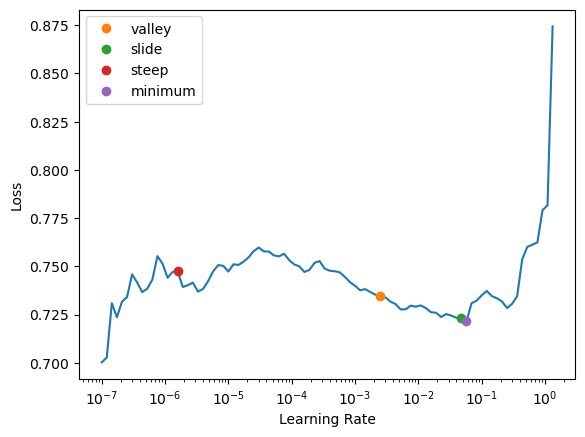

In [22]:
results_dnn = run_deep_nn_experiment(
    df, 
    dataset_1['File'],                 # stuff for logging
    'class1',                # the column we are trying to predict
    (50 for _ in range(1)),           # we use 10 layers with 100 neurons each
    epochs=200,
)

Shape of Input Data: (18758, 24)
Layer sizes: [23, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 7], length: 12
Number of residual blocks: 9
Residual locations:  [1, 2, 3, 4, 5, 6, 7, 8, 9]


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.362779,1.455451,0.513196,0.354445,0.734371,0.381702,0.353323,0.366722,0.354445,00:02
1,1.056573,1.202369,0.576113,0.414558,0.816541,0.463576,0.422140,0.478995,0.414558,00:02
2,0.981454,1.311456,0.529459,0.424485,0.800900,0.419439,0.418443,0.455391,0.424485,00:02
3,0.934816,1.086207,0.631032,0.494595,0.847198,0.535654,0.493808,0.519316,0.494595,00:02
4,0.900735,1.118048,0.612103,0.469732,0.853483,0.509386,0.472771,0.519899,0.469732,00:02
5,0.886135,1.147585,0.598774,0.444060,0.842514,0.491100,0.455179,0.517091,0.444060,00:02
6,0.827652,1.226919,0.547587,0.448524,0.832876,0.443270,0.444825,0.485114,0.448524,00:02
7,0.828104,1.114500,0.623834,0.502832,0.855536,0.530461,0.501642,0.545348,0.502832,00:02
8,0.799721,1.190652,0.579579,0.484712,0.846554,0.483292,0.477674,0.523951,0.484712,00:02
9,0.803047,1.152027,0.591042,0.484145,0.851301,0.493843,0.479455,0.524310,0.484145,00:02


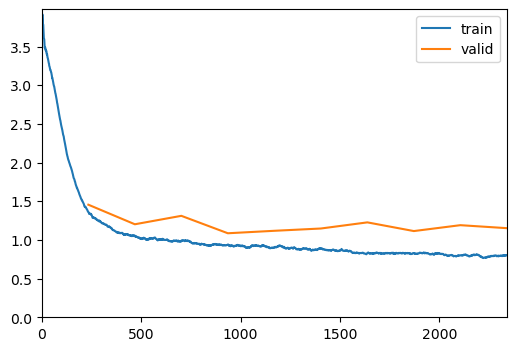

loss: 1.152026653289795, accuracy:  59.10%


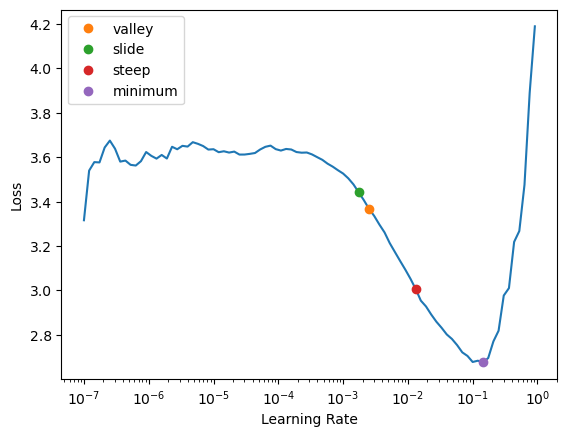

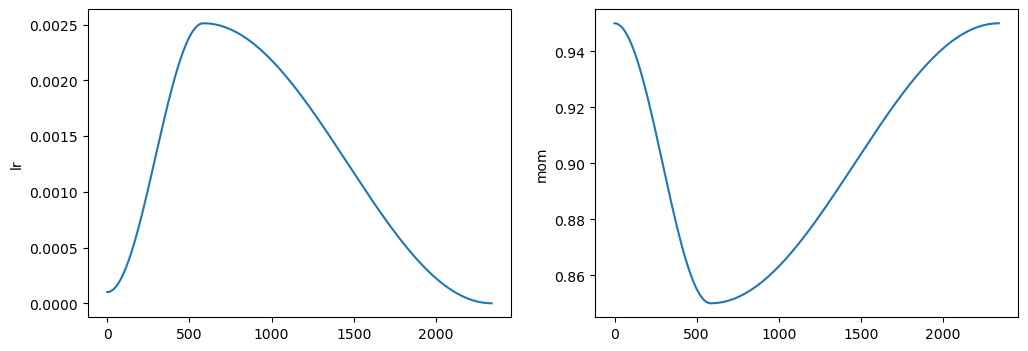

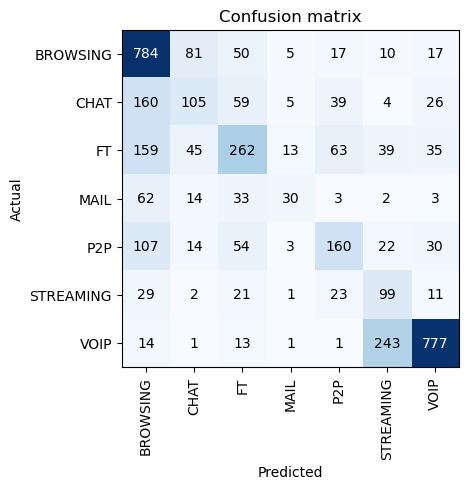

In [12]:
results_res_type_1 = run_residual_deep_nn_experiment(
    df, 
    dataset_1['File'], 
    'class1', 
    (100 for _ in range(10))
)

In [13]:
results_sk = run_sk_experiment(
    df, 
    dataset_1['File'], 
    'class1'
)

Shape of Input Data: (18758, 24)
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       964
           1       0.57      0.56      0.56       398
           2       0.70      0.67      0.68       616
           3       0.78      0.71      0.74       147
           4       0.79      0.67      0.73       390
           5       0.86      0.76      0.81       186
           6       0.99      0.98      0.98      1050

    accuracy                           0.81      3751
   macro avg       0.78      0.75      0.76      3751
weighted avg       0.81      0.81      0.80      3751

	Accuracy: 0.8061850173287124



In [14]:
class BottleneckResidualBlock(nn.ModuleList):
# class BottleneckResidualBlock(Module):
    '''
        A residule block that creates a skip connection around a set of n branches
            where the number of branches is determined by the number of input modules
            in the branches list parameter.

            the residual connection is put through a linear batchnormed layer if the
            input size is different from the output size
            Then, the output of the branches is summed together along with the possibly transformed input
    '''
    def __init__(self, branches: list, layer: int, in_size: int, out_size: int):
        super().__init__(branches)
        
        self.branches = branches
        self.layer = layer

        self.in_size = in_size
        self.out_size = out_size

        if(in_size != out_size):
            self.identity_path = LinBnDrop(in_size, out_size)
        else:
            self.identity_path = Identity()


    def forward(self, inputs):

        fx = self.branches[0](inputs)
        for i in range(len(self.branches) - 1):
            fx += self.branches[i + 1](inputs)

        if(inputs.shape != fx.shape):
            inputs = self.identity_path(inputs)
        return fx + inputs



class Simple_Resnet_Model(nn.Module):
    def __init__(self, input_features=62, layers=[100 for _ in range(10)], output_features=8, config: dict = None, device: str = 'cpu'):
        super().__init__()
        self._layers = []
        _activations = [nn.ReLU(inplace=True) for _ in range(len(layers) - 1)] + [None]

        for i, x in enumerate(layers):
            print(i)
            if (i == 0):
                self._layers.append(BottleneckResidualBlock([LinBnDrop(input_features, layers[i+1], act=_activations[i], lin_first=True)], i, input_features, layers[i+1]))
            elif (i == len(layers) - 1):
                self._layers.append(BottleneckResidualBlock([LinBnDrop(x, output_features, act=_activations[i], lin_first=True)], i, x, output_features))
                # self._layers.append(LinBnDrop(x, output_features, act=_activations[i], lin_first=True))
            else:
                self._layers.append(BottleneckResidualBlock([LinBnDrop(x, layers[i+1], act=_activations[i], lin_first=True)], i, x, layers[i+1]))
        
        self.out = nn.Sequential(*self._layers)     
        
    def forward(self, x):
        return self.out(x)



Shape of Input Data: (18758, 24)
0
1
2
3
4
5
6
7
8
9


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.123525,1.445843,0.551853,0.383000,0.810090,0.444163,0.355113,0.478747,0.383000,00:06
1,1.013713,1.443189,0.443882,0.403010,0.852140,0.353056,0.361501,0.541144,0.403010,00:06
2,0.975123,1.548333,0.395628,0.328398,0.798896,0.284439,0.273963,0.497334,0.328398,00:06
3,0.941225,1.652551,0.456145,0.390229,0.832261,0.362787,0.355075,0.426969,0.390229,00:07
4,0.931765,1.866015,0.423620,0.322772,0.792507,0.295701,0.300448,0.491989,0.322772,00:06
5,0.902856,1.658719,0.371101,0.277780,0.801492,0.266978,0.239806,0.379038,0.277780,00:07
6,0.903443,1.582541,0.415089,0.374627,0.822309,0.320556,0.302763,0.413541,0.374627,00:06
7,0.871896,1.717377,0.415889,0.350432,0.834513,0.315744,0.287812,0.362083,0.350432,00:06
8,0.851470,1.656643,0.380698,0.339519,0.841068,0.297994,0.310886,0.435529,0.339519,00:06
9,0.864191,1.620057,0.424953,0.362793,0.831351,0.330199,0.335037,0.451532,0.362793,00:06


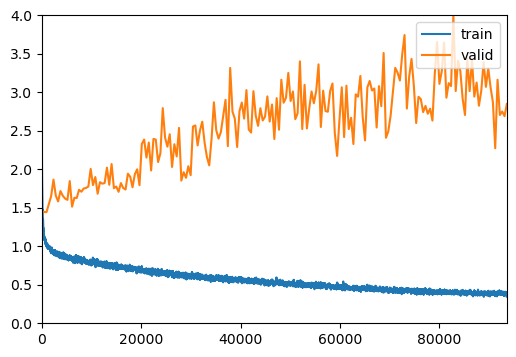

c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 2.847996234893799, accuracy:  20.21%


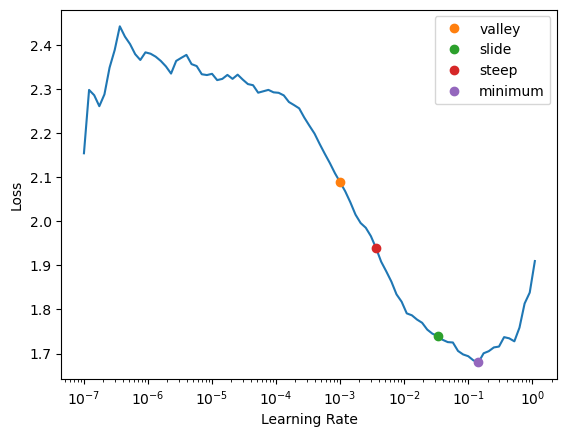

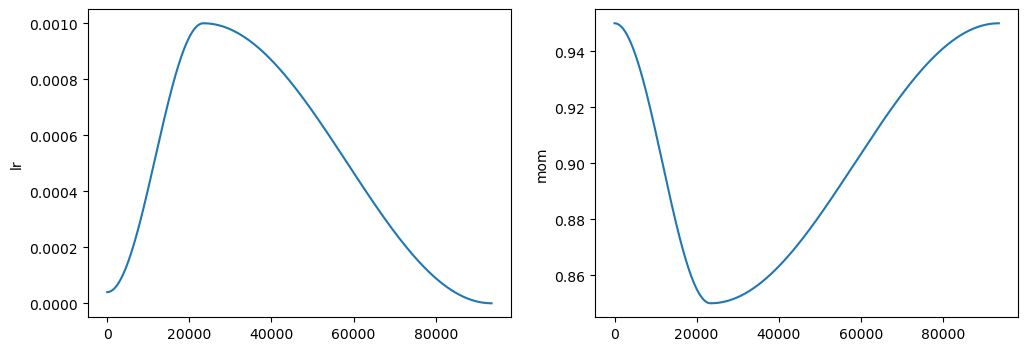

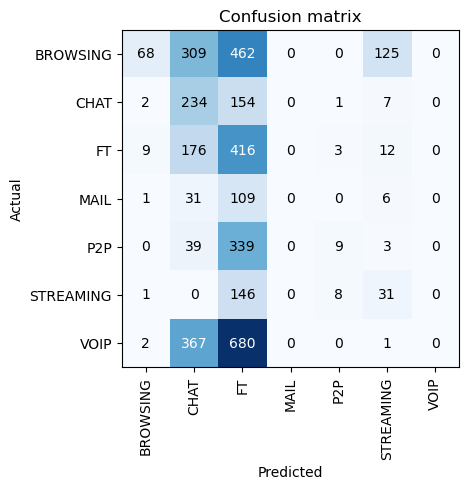

In [21]:
results_res_type_2 = run_torch_nn_experiment(
    df, 
    dataset_1['File'], 
    'class1', 
    Simple_Resnet_Model,
    config={ 'layers': [100 for _ in range(10)]},
    epochs=200,
    batch_size=32
    
)

In [16]:
model_1 = results_dnn.model.model.model
model_2 = results_res_type_1.model.model.model
model_3 = results_res_type_2.model.model.model

results_1 = results_dnn.model.model.validate()
results_2 = results_res_type_1.model.model.validate()
results_3 = results_res_type_2.model.model.validate()

print(f"Deep NN 100x10: \t\t\t{sum(p.numel() for p in model_1.parameters() if p.requires_grad)} parameters, {results_1[1]*100} accuracy")
print(f"Deep Res NN 100x10: \t\t\t{sum(p.numel() for p in model_2.parameters() if p.requires_grad)} parameters, {results_2[1]*100} accuracy")
print(f"Simple Res NN 100x10: \t\t{sum(p.numel() for p in model_3.parameters() if p.requires_grad)} parameters, {results_3[1]*100} accuracy")

Deep NN 100x10: 			95053 parameters, 40.81578254699707 accuracy
Deep Res NN 100x10: 			95053 parameters, 59.10423994064331 accuracy
Simple Res NN 100x10: 		88106 parameters, 44.86803412437439 accuracy


In [1]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
assert False, f"Nothing after this point is included in the study. Time: {timestamp}"

NameError: name 'datetime' is not defined